# Getting started with UnrealCV

This chapter will show the basic usage of UnrealCV python client. Before running this tutorial make sure you have set up UnrealCV plugin in your Unreal Engine project, instructions can be found [here](./docs/1_setup.md).

Let's start by importing the necessary libraries.

In [ ]:
import sys
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from unrealcv import client

### Connect to the game

The unrealcv library provides a default client to connect to the game a different client can be created by calling `unrealcv.Client`. The two main function that a `Client` object provides are `connect` and `request`. The `connect` function is used to connect to the game and the `request` function is used to send a command to the game. In the snippet below, we connect to the game and check if the connection is successful by sending a `vget /unrealcv/status` command.

In [3]:
# Connect to the UnrealCV server
client.connect()
if not client.isconnected():
    print('UnrealCV server is not running. Run the game downloaded from http://unrealcv.github.io first.')
    sys.exit(-1)
print(client.request('vget /unrealcv/status'))

INFO:__init__:234:Got connection confirm: b'connected to CityPark'


=> Info: Use inet client...
=>Info: using ip-port socket
Is Listening
Client Connected
9000
Configuration
Config file: C:/Program Files/Epic Games/UE_4.27/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 640
Height: 480
FOV: 90.000000
EnableInput: true
EnableRightEye: false



### Basic commands

The most useful commands are the ones used to capture an image. UnrealCV provides different "sensors" to capture images:
- `vget /camera/0/lit` captures an image from the first camera with default lighting.
- `vget /camera/0/depth` captures the depth image from the first camera.
- `vget /camera/0/object_mask` captures the object mask from the first camera.
- `vget /camera/0/normal` captures the normal surface from the first camera.

The following code snippet captures an lit image and the object mask from the first camera and displays it.

In [ ]:
res = client.request('vget /camera/0/lit png')
# Its is also possible to directly save the image to disk
# client.request('vget /camera/0/lit tmp.png')
im = PIL.Image.open(BytesIO(res))
# Visualize the image we just captured
plt.imshow(im)

# Get object mask
res = client.request('vget /camera/0/object_mask png')
im = PIL.Image.open(BytesIO(res))
plt.imshow(im)

The result should look something like this:

Lit image                  |  Object mask
:-------------------------:|:-------------------------:
![](./docs/imgs/lit.png)   |  ![](./docs/imgs/seg.png)

For the depth sensors data is retrieved as a numpy array:

In [ ]:
res = client.request('vget /camera/0/depth npy')
np.load(BytesIO(res))

Now that we have the segmented image we may want to know which object has which color. To get the ids of the objects in the scene we can use the `vget /objects` command, this will return a list of objects with their ids. Then we can retrieve the color of a specific object by using the `vget /object/[id]/color` command.

In [ ]:
res = client.request('vget /objects')
print(res)
res = client.request('vget /object/[obj_name]/color')
print(res)

UnrealCV offers a lot of other functionalities, like moving tha cameras in space and getting the position of the objects. Other commands will be used in order to create the dataset. For a complete list of commands check the [documentation](./docs/commands.txt).

# Getting the images from UnrealCV

With the UnrealCV plugin installed in the Unreal Engine project, we can now start capturing images from the game. 

In Unreal Engine I have placed some cameras to reproduce security cameras in a city park. The goal is to capture images from rotating the cameras and changing the time of the day, to create a dataset for a surveillance system. The system will be able to detect people in the park.

> **Note:** This particular code is used to retrive images from the scene that *I* created, and probably won't work for you. This is just an example of how to use the UnrealCV plugin to get images from the game.

Import the necessary libraries:

In [ ]:
import re, sys, os, random, json
import PIL.Image
from io import BytesIO
from tqdm import tqdm        # pip install tqdm
from unrealcv import client
client.connect()

### Get the colors of the objects

The first step is to get the colors of the objects in the scene. This is done by using the `vget /objects` command to get the ids of the objects and then using the `vget /object/[id]/color` command to get the color of the object. The only objects that we are interested in are the people, so we will only save the colors of the people (in my case people objects names start with "SM_Child", "SM_Couple", etc.).

If the program encounter repeated colors it will panic and stop the execution.

In [5]:
def parse_color(color_str):
    """
    Parse the color string returned by the UnrealCV server to a tuple of integers
    """
    numbers = re.findall(r'\d+', color_str)

    # Convert the list of strings to a list of integers
    array = list(map(int, numbers))
    return (array[0], array[1], array[2])

# Get the list of all objects in the scene
scene_objects = client.request('vget /objects').split(' ')
# Remove the last empty string
scene_objects.pop()

person_colors = set()
for obj in scene_objects:
    # Get the color of the object
    color_str = client.request('vget /object/%s/color' % obj)
    color = parse_color(color_str)
    if (obj.startswith('SM_Child') or obj.startswith('SM_Couple') or obj.startswith('SM_Man') or obj.startswith('SM_Trio') or obj.startswith('SM_Woman')) and not obj.startswith('SM_Manhole'):
        if not color in person_colors:
            # If it is a person, add the color to the set
            person_colors.add(color)
        else:
            print('Duplicate color:', color)
            sys.exit(-1)
    elif color in person_colors:
        print('Duplicate color:', color)
        sys.exit(-1)

# Save the set of person colors to a file
json.dump(person_colors, open('./data/color_set.json', 'w'), default=list)

### Set camera properties

The next step is to set the camera properties. Trough the unrealcv commands we can set the image resolution, the field of view, and even the projection type. More option can be changed in the Unreal Editor. In this case, we will set the resolution to 1080x720 and the field of view to 80 degrees. The `ROTATION_FACTOR` is the amount of degrees that the camera will rotate in each iteration.

Set variables:

In [4]:
IMG_WIDTH = 1080
IMG_HEIGHT = 720
IMG_FOV = 80
ROTATION_FACTOR = 1

Set properties of each camera

In [5]:
CAMERAS = len(client.request('vget /cameras').split(' ')) - 1

for i in range(CAMERAS):
    client.request('vset /camera/%d/size %d %d' % (i, IMG_WIDTH, IMG_HEIGHT))
    client.request('vset /camera/%d/fov %d' % (i, IMG_FOV))

### Capture images

Now we can start capturing images. The `get_images()` function iterates over the cameras, for each one it rotates the camera by the `ROTATION_FACTOR` and captures an image with the provided sensor. The images are saved in the `/data/training` folder.

In [6]:
def parse_rotation(rotation_str):
    # Use regular expression to find all numbers including negatives and decimals
    numbers = re.findall(r'-?\d+\.\d+', rotation_str)

    # Convert the list of strings to a list of floats
    array = list(map(float, numbers))
    return (array[0], array[1], array[2])

def get_images(camera_type, additional_name):
    i = 0
    for cam in tqdm(range(1, CAMERAS)): # skip the first camera
        # get camera rotation
        rot_str = client.request('vget /camera/%d/rotation' % cam)
        rot = parse_rotation(rot_str)
        rotation_angle = 0
        while rotation_angle < 360:
            # set camera rotation
            client.request('vset /camera/%d/rotation %f %f %f' % (cam, rot[0], rotation_angle, rot[2]))
            rotation_angle += ROTATION_FACTOR
            i += 1
            # get the object mask
            object_mask_bytes = client.request('vget /camera/%d/%s png' % (cam, camera_type))
            object_mask = PIL.Image.open(BytesIO(object_mask_bytes))
            object_mask.save("./data/training/%s/%d%s.png" % (camera_type, i, additional_name))

Now we can call the `get_images()` function to start capturing the segmented images. In my case, I have 18 cameras in the scene. This will take a while.

In [6]:
get_images('seg', '')

Since the scene is static (unrealcv doesn't support dynamic objects) we can capture the lit images and the segmented images in different times. In this way we can capture different lit images for the same segmented image. We can use this to capture images in different times of the day, just change the light in the Unreal Engine Editor and run the code again.

In [7]:
# The second argument is the additional name to add to the file name
# I captured 3 different lighting conditions
get_images('lit', '_3')

100%|██████████| 18/18 [1:26:01<00:00, 286.73s/it]


Now that we have captured the images we can split them into a training and a validation sets.

In [61]:
# take 10% of the files for validation
random.seed(0)
file_names = os.listdir("./data/training/seg")
random.shuffle(file_names)
split = int(0.1 * len(file_names))
val_files = file_names[:split]
# move the files to the validation folder
for file in val_files:
    # move the segmentation files
    os.rename("./data/training/seg/%s" % file, "./data/validation/seg/%s" % file)
    for i in range(1, 4):
        # move the lighting files
        os.rename(
            "./data/training/lit/%s" % file.replace('.png', '_%d.png' % i), 
            "./data/validation/lit/%s" % file.replace('.png', '_%d.png' % i)
        )

# Creating the dataset

Now that we have the images we can create the dataset. The dataset follows the structure of the [COCO dataset](https://cocodataset.org/#format-data).

Import the necessary libraries:

In [7]:
import os, json
import PIL.Image
import numpy as np
from tqdm import tqdm

In order to create the dataset the following is need:

- The set of the colors of the people in the scene: `color_set`
- The segmented images

For each segmented image the following steps are taken:

- Get the colors captured in the segmented image
- Intersect the colors found with `color_set`. This will give us all the colors of the people in the image.
- For each color found the bounding box that contains the color in the segmented image is found
- Save the bounding box in the coco format

This method is not the most efficient, but seems the best way to do it with the tools provided by UnrealCV.

If the amount of pixel of the same color is less than a threshold the color is ignored. This is done because UnrealCV can detect every pixel of an object, even if only a single pixel is visible.

In [8]:
def get_color_box(color, object_mask):
    """
    Get the bounding box of the object with the specified color in the object mask
    """
    # Create a boolean mask where the color matches
    mask = np.all(object_mask[:, :, :3] == color, axis=-1)
    
    # Check if enough matching pixels are found
    if np.sum(mask) < object_mask.shape[0] * object_mask.shape[1] * 1.75e-4:
        return (False, [0, 0, 0, 0])
    
    # Find the indices where mask is True
    y_indices, x_indices = np.nonzero(mask)
    
    # Find min and max indices
    min_x, max_x = int(np.min(x_indices)), int(np.max(x_indices))
    min_y, max_y = int(np.min(y_indices)), int(np.max(y_indices))
    
    # COCO format
    coco_box = [min_x, min_y, max_x - min_x, max_y - min_y]

    return (True, coco_box)

def get_unique_colors(image):
    """
    Get the unique colors in an image
    """
    # Reshape the image to a 2D array where each row is a color
    reshaped_image = image[:, :, :3].reshape(-1, 3)
    
    # Use np.unique to find the unique rows (colors)
    unique_colors = np.unique(reshaped_image, axis=0)

    # Convert to a set of tuples
    unique_colors_set = set(map(tuple, unique_colors))
    
    return unique_colors_set


def get_bounding_boxes(object_mask, color_set):
    """
    Get the bounding boxes of all objects in the segmented image with colors in the color set
    """
    # Get the colors of the objects in the image
    image_colors = get_unique_colors(object_mask) & color_set
    bounding_boxes = []
    for color in image_colors:
        # Get the bounding box of the object with the specified color
        is_present, box = get_color_box(color, object_mask)
        if is_present:
            # If the object is present, add the bounding box to the list
            bounding_boxes.append(box)
    return bounding_boxes


def create_coco_format_json(seg_path, color_set, rounds):
    """
    Create a COCO format dataset from the segmented images in the seg_path directory

    seg_path: The path to the directory containing the segmented images
    color_set: The set of colors to include in the dataset
    rounds: The number of round associated to one object_mask image
    """
    images = []
    annotations = []
    categories = [{ "id": 1, "name": "person"}]
    count = 0

    file_names = os.listdir(seg_path)
    
    # Iterate over image filepaths
    for filepath in tqdm(file_names):
        # Get the file name
        seg_file_name = filepath.split("/")[-1]
        # Get the image id
        seg_file_id = seg_file_name.split(".")[0]

        # Open the segmented image
        img_file = PIL.Image.open("%s/%s" % (seg_path, seg_file_name))
        image = np.array(img_file)
        img_file.close()
        width = image.shape[1]
        height = image.shape[0]

        # compute the bounding boxes
        bounding_boxes = get_bounding_boxes(image, color_set)
        
        # For each round
        for i in range(1, rounds+1):
            id = int(seg_file_id + "%d" % i)
            # Add the image to the dataset
            images.append(
                {
                    "id": id,
                    "width": width,
                    "height": height,
                    "file_name": seg_file_id + "_%d.png" % i
                }
            )

            # Add the bounding boxes to the dataset
            for box in bounding_boxes:
                seg = {
                    'bbox': box,
                    'image_id': id, 
                    'category_id': 1, 
                    'iscrowd': 0, 
                    'id': count
                }
                annotations.append(seg)
                count += 1
            
    # Create the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format

Now we can load the color set and start creating the dataset! This will take a while.

In [9]:
# Read the color set from the file
color_list = json.load(open('./data/color_set.json'))
color_set = set(map(tuple, color_list))
# Create the dataset
dataset = create_coco_format_json("./data/validation/seg", color_set, 3)
json.dump(dataset, open('./data/validation/dataset_validation.json', 'w'))

100%|██████████| 648/648 [21:13<00:00,  1.97s/it]


# See the results

Now that we have the dataset we can see the results. The following code will display the bounding boxes of the people in an image.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pycocotools.coco import COCO

In [44]:
# Load the COCO dataset
coco = COCO('./data/training/dataset_training_test.json')

# Function to display an image with its bounding boxes
def display_image_with_bboxes(image_id, img_path):
    # Get the image metadata
    img_info = coco.loadImgs(image_id)[0]
    image_path = f"%s/{img_info['file_name']}" % img_path
    
    # Open the image
    image = Image.open(image_path)
    
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Get the annotations for the image
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)
    
    # Draw each bounding box
    for annotation in annotations:
        bbox = annotation['bbox']
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Display the bounding boxes of the people in the image chosen

{'id': 11, 'width': 1080, 'height': 720, 'file_name': '1_1.png'}
[{'bbox': [614, 125, 12, 25], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 0}, {'bbox': [319, 186, 14, 39], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 1}, {'bbox': [303, 188, 13, 46], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 2}, {'bbox': [444, 129, 7, 33], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 3}, {'bbox': [141, 231, 26, 45], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 4}, {'bbox': [346, 189, 12, 42], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 5}, {'bbox': [179, 181, 15, 39], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 6}, {'bbox': [174, 238, 26, 34], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 7}, {'bbox': [588, 170, 13, 53], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 8}, {'bbox': [877, 133, 12, 44], 'image_id': 11, 'category_id': 1, 'iscrowd': 0, 'id': 9}, {'bbox': [291, 183, 16, 46], 'image_id': 11, 'category_id': 1, 'i

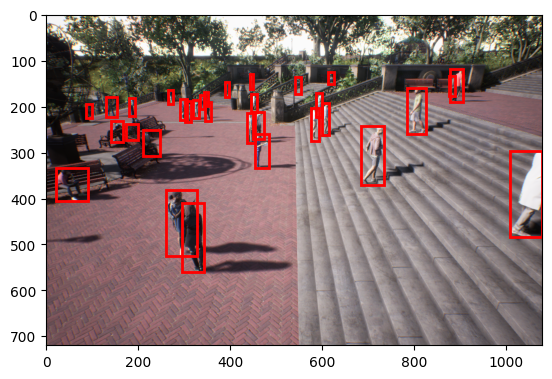

In [45]:
display_image_with_bboxes(11, "./data/training/lit")